In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728125168.269875      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1005 10:46:08.277836377      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1005 10:46:08.277851132      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1005 10:46:08.277854579      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1005 10:46:08.277857071      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1005 10:46:08.277859631      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728125275.962708      13 service.cc:145] XLA service 0x5bac93989580 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728125275.962778      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728125275.962782      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728125275.962785      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728125275.962788      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728125275.962792      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728125275.962799      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728125275.962801      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728125275.962804      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

model.summary()

I0000 00:00:1728125281.080281      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 16, 32, 1920)   │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,568,130 (70.83 MB)

 Trainable params: 246,146 (961.51 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-DenseNet201_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-05 10:50:52.587178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728125455.319528     836 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2b7a5b771863a0ac:0:0), session_name()


  1/223 ━━━━━━━━━━━━━━━━━━━━ 2:31:23 41s/step - accuracy: 0.2500 - loss: 0.8567

I0000 00:00:1728125481.955701     836 tpu_compile_op_common.cc:245] Compilation of 2b7a5b771863a0ac:0:0 with session name  took 26.636102039s and succeeded
I0000 00:00:1728125481.997400     836 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2b7a5b771863a0ac:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6479006451612996843", property.function_library_fingerprint = 11623232247065220027, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728125481.997453     836 tpu_compilation_cache_interface.cc:541] After adding entry for key

222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5962 - loss: 0.6752

I0000 00:00:1728125522.632134     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(85bac058f22db921:0:0), session_name()


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5963 - loss: 0.6751

I0000 00:00:1728125543.235045     835 tpu_compile_op_common.cc:245] Compilation of 85bac058f22db921:0:0 with session name  took 20.6028608s and succeeded
I0000 00:00:1728125543.266809     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(85bac058f22db921:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6479006451612996843", property.function_library_fingerprint = 11623232247065220027, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728125543.266846     835 tpu_compilation_cache_interface.cc:541] After adding entry for key 8

223/223 ━━━━━━━━━━━━━━━━━━━━ 189s 665ms/step - accuracy: 0.5964 - loss: 0.6750 - val_accuracy: 0.6413 - val_loss: 0.6471
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.6701 - loss: 0.6225 - val_accuracy: 0.6323 - val_loss: 0.6395
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.6902 - loss: 0.6067 - val_accuracy: 0.6726 - val_loss: 0.6249
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - accuracy: 0.6965 - loss: 0.5969 - val_accuracy: 0.6413 - val_loss: 0.6395
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.6718 - loss: 0.5948 - val_accuracy: 0.6457 - val_loss: 0.6233
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.6874 - loss: 0.6046 - val_accuracy: 0.6413 - val_loss: 0.6325
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - accuracy: 0.6982 - loss: 0.5676 - val_accuracy: 0.6592 - val_loss: 0.6245
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 237ms/step - accuracy: 0.6764 - loss: 0.57

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.6559 - loss: 0.6626
Test accuracy: 67.26%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-05 11:20:40.421964: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728127241.829579     753 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c634b7a8629e5c75:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 24:28 27s/step

I0000 00:00:1728127259.744830     753 tpu_compile_op_common.cc:245] Compilation of c634b7a8629e5c75:0:0 with session name  took 17.915190426s and succeeded
I0000 00:00:1728127259.783253     753 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c634b7a8629e5c75:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_1499229103356940194", property.function_library_fingerprint = 8137394387319957077, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728127259.783298     753 tpu_compilation_cache_interface.cc:541] After adding entry for key c634b7a8629

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step

I0000 00:00:1728127288.711788     753 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cfd314dbef1aa09f:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 842ms/step


I0000 00:00:1728127306.078215     753 tpu_compile_op_common.cc:245] Compilation of cfd314dbef1aa09f:0:0 with session name  took 17.366381168s and succeeded
I0000 00:00:1728127306.110696     753 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cfd314dbef1aa09f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_6128640456759088612", property.function_library_fingerprint = 3946251202448775069, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728127306.110739     753 tpu_compilation_cache_interface.cc:541] After adding entry for k

Accuracy: 0.6646067415730337
Precision: 0.6724188509902795
Recall: 0.6647256214185349
F1 Score: 0.6608637624380431
Number of Epochs: 13
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step


<Figure size 1600x1600 with 0 Axes>

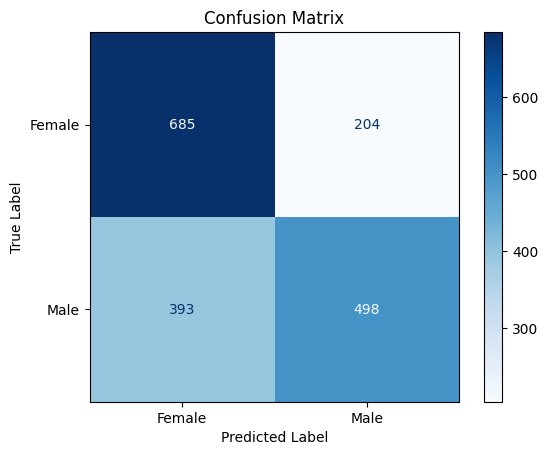

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

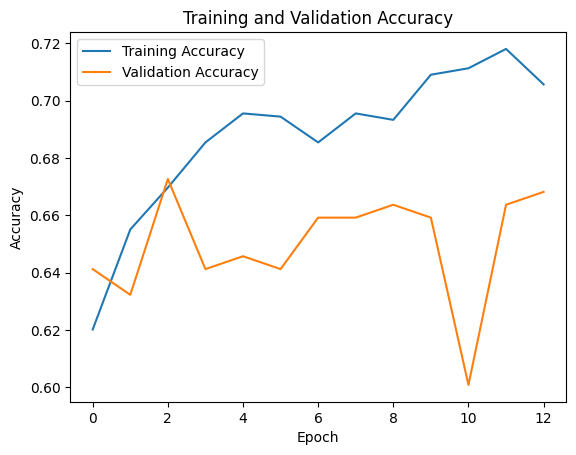

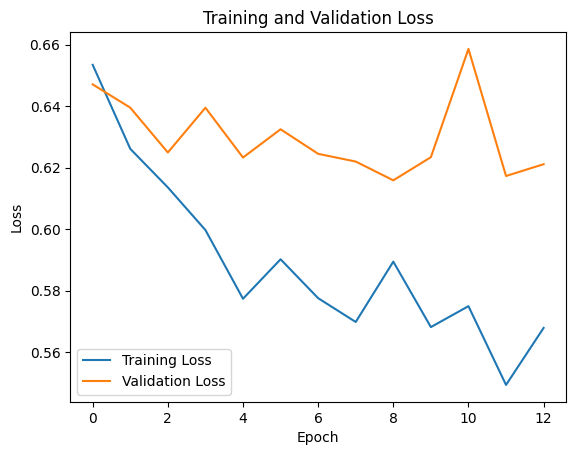

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()